In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.io import imread
from skimage import img_as_ubyte

# Data loading

In [2]:
dataset = pd.read_csv('Z1-picture_cropping.csv', index_col=0, dtype={'foldername':'object'})
dataset.head()

,breed,file,xmin,ymin,xmax,ymax,foldername,filename,dog_number,prepfilename,xdelta,ydelta
n02085620_10074,Chihuahua,n02085620_10074,25.0,10.0,276.0,498.0,02085620,n02085620_10074,1,n02085620_10074-Chihuahua_cr1,251.0,488.0
n02085620_10131,Chihuahua,n02085620_10131,49.0,9.0,393.0,493.0,02085620,n02085620_10131,1,n02085620_10131-Chihuahua_cr1,344.0,484.0
n02085620_10621,Chihuahua,n02085620_10621,142.0,43.0,335.0,250.0,02085620,n02085620_10621,1,n02085620_10621-Chihuahua_cr1,193.0,207.0
n02085620_1073,Chihuahua,n02085620_1073,0.0,27.0,312.0,498.0,02085620,n02085620_1073,1,n02085620_1073-Chihuahua_cr1,312.0,471.0
n02085620_10976,Chihuahua,n02085620_10976,90.0,104.0,242.0,452.0,02085620,n02085620_10976,1,n02085620_10976-Chihuahua_cr1,152.0,348.0


In [102]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(dataset['breed'])
#print(le.classes_)
dataset['breed_code'] = le.transform(dataset['breed'])
dataset.head()

,breed,file,xmin,ymin,xmax,ymax,foldername,filename,dog_number,prepfilename,xdelta,ydelta,breed_code
n02085620_10074,Chihuahua,n02085620_10074,25.0,10.0,276.0,498.0,02085620,n02085620_10074,1,n02085620_10074-Chihuahua_cr1,251.0,488.0,17
n02085620_10131,Chihuahua,n02085620_10131,49.0,9.0,393.0,493.0,02085620,n02085620_10131,1,n02085620_10131-Chihuahua_cr1,344.0,484.0,17
n02085620_10621,Chihuahua,n02085620_10621,142.0,43.0,335.0,250.0,02085620,n02085620_10621,1,n02085620_10621-Chihuahua_cr1,193.0,207.0,17
n02085620_1073,Chihuahua,n02085620_1073,0.0,27.0,312.0,498.0,02085620,n02085620_1073,1,n02085620_1073-Chihuahua_cr1,312.0,471.0,17
n02085620_10976,Chihuahua,n02085620_10976,90.0,104.0,242.0,452.0,02085620,n02085620_10976,1,n02085620_10976-Chihuahua_cr1,152.0,348.0,17


In [4]:
#dataset downsizing
dataset = dataset[dataset['breed_code'] <=20]
dataset.shape

(3629, 13)

# OpenCV features

In [5]:
import cv2

## Swift

(array([[ 65.,   9.,  52., ...,   0.,   0.,   1.],
       [  8.,   2.,   1., ...,  23.,  13.,   1.],
       [ 92.,  23.,   0., ...,  20.,  13.,  11.],
       ...,
       [  0.,   0.,   0., ...,  10.,  32.,  20.],
       [119.,   7.,   1., ...,   0.,   0.,   0.],
       [137.,  33.,   3., ...,   0.,   0.,   0.]], dtype=float32), array([[[162,  62,  60],
        [152,  52,  50],
        [146,  43,  44],
        ...,
        [226, 158, 137],
        [215, 144, 124],
        [207, 132, 113]],

       [[163,  65,  64],
        [151,  51,  51],
        [143,  40,  43],
        ...,
        [234, 166, 143],
        [224, 153, 131],
        [215, 143, 121]],

       [[173,  74,  77],
        [159,  58,  62],
        [149,  46,  50],
        ...,
        [220, 153, 126],
        [214, 144, 118],
        [207, 135, 110]],

       ...,

       [[115, 109,  51],
        [101,  95,  35],
        [ 91,  87,  26],
        ...,
        [142, 167, 109],
        [123, 143,  80],
        [108, 123,  56]]

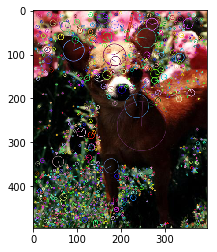

In [6]:
def sift_features(picture):
    imcv = img_as_ubyte(picture)
    imcv_gr = cv2.cvtColor(imcv, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    
    imcv_kp, imcv_desc = sift.detectAndCompute(imcv_gr, None)
    
    #plt.imshow(cv2.drawKeypoints(imcv, imcv_kp, imcv,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    
    return imcv_desc, cv2.drawKeypoints(imcv, imcv_kp, imcv,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

picture = imread('../Images/n02085620-Chihuahua/n02085620_10131.jpg')
print(sift_features(picture))
plt.imshow(picture)

## Dominant color

In [7]:
def color_domincance(picture, n_cluster=20):
    #Converts to openCV
    imcv = img_as_ubyte(picture)
        
    #Flatten all the pixels
    Z = imcv.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = n_cluster
    ret, label, color_dominance = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    return color_dominance

picture = imread('../Images/n02085620-Chihuahua/n02085620_10131.jpg')
color_domincance(picture)

array([[ 35.674004 ,  58.184067 ,  32.712276 ],
       [251.75835  , 233.06233  , 226.43938  ],
       [178.93512  , 168.6346   , 126.18691  ],
       [109.27871  ,  20.615084 ,  13.917275 ],
       [ 83.13699  , 103.46002  ,  70.40139  ],
       [ 59.862686 ,  78.891106 ,  49.039318 ],
       [128.11893  ,  47.04774  ,  32.86129  ],
       [121.91851  , 130.636    ,  94.09295  ],
       [231.6364   , 134.4089   , 145.86711  ],
       [ 59.788063 ,  15.047878 ,   8.208531 ],
       [208.49261  ,  66.50082  , 101.78181  ],
       [242.98468  , 191.40956  , 176.50313  ],
       [ 81.81654  ,  30.093346 ,  20.566544 ],
       [ 18.179216 ,   6.9120107,   4.333307 ],
       [  2.517321 ,   4.64038  ,   2.6082225],
       [ 49.612137 ,  32.845234 ,  21.300709 ],
       [ 16.442322 ,  32.80054  ,  16.051401 ],
       [192.96107  , 117.79723  ,  82.96345  ],
       [168.47447  ,  66.32093  ,  48.018852 ],
       [ 35.451385 ,  15.526252 ,   9.112034 ]], dtype=float32)

# Picture loading and treatment

In [8]:
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import gaussian
from skimage import exposure
from skimage.util import crop
from PIL import Image

def pictureloader(picture, save_file=True):
    
    xmax = int(picture.xmax)
    ymax = int(picture.ymax)
    xmin = int(picture.xmin)
    ymin = int(picture.ymin)
    foldername = picture.foldername
    breed = picture.breed
    filename = picture.filename
    prepfilename = picture.prepfilename
    breed_code = picture.breed_code
        
    #Image opening
    img = imread('../Images/n{}-{}/{}.jpg'.format(foldername, breed, filename))
            
    #Image cropping
    area = (xmin, ymin, xmax, ymax)
    img = Image.fromarray(img).crop(area)
    img=np.array(img)
            
    #Image equalization
    img = exposure.equalize_hist(img)
            
    #Gaussian blur fliter
    img = gaussian(img, sigma=1, multichannel=True)
    
    
    #Non linear mean
    patch_kw = dict(patch_size=5,      # 5x5 patches
                        patch_distance=6,  # 13x13 search area
                        multichannel=True)
    #sigma_est = np.mean(estimate_sigma(img, multichannel=True, average_sigmas=False))
    #img = denoise_nl_means(img, h=10*sigma_est, fast_mode=True, **patch_kw)

    descriptors, pic = sift_features(img)
    colors = color_domincance(img)
    
    #plt.imshow(pic)
    #plt.show()
    
    if save_file:
        cv2.imwrite('../pics/{}.jpg'.format(prepfilename),pic)

    
    return descriptors, colors, breed_code

descriptors, colors , breed_code = pictureloader(dataset.iloc[1])

/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Dataset creation

In [47]:
keypoints = []
colors = []
y = []

for _, picture in dataset.iterrows():
    descriptors, colorsdom, breed = pictureloader(picture, save_file=False)
    keypoints.append(descriptors)
    colors.append(colorsdom)
    y.append(breed)

X = np.array([keypoints, colors])
y = np.array(y)

/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Dataset saving

In [49]:
np.savez('Z2 - bowsift', X=X, y=y)

# Dataset loading

In [9]:
saved = np.load('Z2 - bowsift.npz')
saved.files

['X', 'y']

In [10]:
X = saved['X']
y = saved['y']

In [11]:
d = {'kp':X[0], 'colors':X[1], 'breed':y}
df = pd.DataFrame(data=d)
df['colors'] = df['colors'].apply(np.array)
df['kp'] = df['kp'].apply(np.array)
df.head()

,breed,colors,kp
0,17,"[[225.183, 215.0582, 203.66414], [245.17618, 2...","[[10.0, 150.0, 73.0, 8.0, 1.0, 0.0, 0.0, 1.0, ..."
1,17,"[[220.76161, 175.43912, 151.00299], [137.83487...","[[0.0, 40.0, 59.0, 20.0, 48.0, 23.0, 4.0, 0.0,..."
2,17,"[[87.80137, 58.983776, 42.832012], [38.192036,...","[[0.0, 0.0, 0.0, 0.0, 31.0, 152.0, 6.0, 0.0, 9..."
3,17,"[[43.866714, 44.879726, 23.525673], [72.696915...","[[2.0, 1.0, 2.0, 35.0, 101.0, 51.0, 11.0, 3.0,..."
4,17,"[[253.18033, 243.05464, 220.67212], [66.120285...","[[40.0, 20.0, 6.0, 0.0, 2.0, 2.0, 5.0, 33.0, 6..."


# Dataset downsizing

In [13]:
df['breed'].unique()

array([17,  8,  0, 20,  3,  6, 10,  2,  5, 18, 11, 16, 14,  9, 12, 19,  7,
        4, 13, 15,  1])

In [14]:
df = df[df['breed']<5]
df['breed'].unique()

array([0, 3, 2, 4, 1])

# Data separation

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['kp', 'colors']], df['breed'], test_size=0.33, random_state=0, stratify=df['breed'])


# Blocs creation

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

## Standardisation

In [31]:
from sklearn.preprocessing import StandardScaler

class Standselector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.scaler = StandardScaler()
        self.column = column
    
    def fit(self, X, y=None):
        Xasm = np.concatenate(X[self.column].tolist())
        self.scaler.fit(Xasm)
        return self
        
    
    def transform(self, X, y=None):
        toreturn = []
        for color in X[self.column]:
            toreturn.append(self.scaler.transform(color))
        return toreturn

colorstand = Standselector('kp')
#colorstand.fit(X_train)
#color_std = colorstand.transform(X_train)
#color_std

## Kmeans

In [32]:
from sklearn.cluster import KMeans
import inspect

class KmeansPlus(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=50, verbose=0, random_state=0):
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
        
    
    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters,
                             verbose=self.verbose,
                             random_state=self.random_state)
        Xasm = np.concatenate(X)
        
        idx = np.random.randint(Xasm.shape[0], size=10000)
        Xsample = Xasm[idx,:]
        
        self.kmeans.fit(Xsample)
        return self
        
    
    def transform(self, X, y=None):
        toreturn = []
        for color in X:
            color = self.kmeans.predict(color)
            toappend = ' '.join(['c{}'.format(x) for x in color])
            toreturn.append(toappend)
        return toreturn

colorkmeans = KmeansPlus()
#colorkmeans.fit(color_std)
#bagofcolors = colorkmeans.transform(color_std)
#bagofcolors

## Counvectorizer

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

class CvectPlus(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        self.params = {'max_df':1.0, 'min_df':1, 'max_features':None, 'analyzer':'word', **kwargs}
        self.cvect = CountVectorizer(**self.params)
    
    def fit(self, X, y=None):
        self.cvect.fit(X)
        return self
        
    
    def transform(self, X, y=None):
        return self.cvect.transform(X)
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.kmeans.set_params(**params)
        return self

colorcvect = CvectPlus()
#colorcvect.fit(bagofcolors)
#colorcvect.transform(bagofcolors)

# Pipelines creation

In [34]:
from sklearn.pipeline import Pipeline

In [35]:
#Color pipe
pipecol = [('stdcol', Standselector('colors')), ('kmcol',KmeansPlus()), ('cvectcol', CvectPlus())]
colorpipe = Pipeline(pipecol)

In [36]:
#descriptors pipe
pipekp = [('stdkp', Standselector('kp')), ('kmkp',KmeansPlus()), ('cvectkp', CvectPlus())]
kppipe = Pipeline(pipekp)

# Feature Union doesn't work with gridsearch, so...

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class FeatureunionPlus(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        self.params = {'kp_n_clusters':10, 'color_n_clusters':10, **kwargs}
        
        self.kp_scaler = StandardScaler()
        self.color_scaler = StandardScaler()
        self.kp_kmeans = KMeans(n_clusters=self.params['kp_n_clusters'])
        self.color_kmeans = KMeans(n_clusters=self.params['color_n_clusters'])
    
    def fit(self, X, y=None):
        keyp = X['kp'].tolist()
        colors = X['colors'].tolist()
        
        Xkpasm = np.concatenate(keyp)
        Xcolorsasm = np.concatenate(colors)
        
        idx = np.random.randint(Xkpasm.shape[0], size=5000)
        Xkpsample = Xkpasm[idx,:]
        
        idx = np.random.randint(Xcolorsasm.shape[0], size=5000)
        Xcolorssample = Xcolorsasm[idx,:]
        
        Xcolscaled = self.color_scaler.fit_transform(Xcolorssample)
        Xkpscaled = self.kp_scaler.fit_transform(Xkpsample)
        
        self.kp_kmeans.fit(Xkpscaled)
        self.color_kmeans.fit(Xcolscaled)
        
        return self
        
    
    def transform(self, X, y=None):
        keyp = X['kp'].tolist()
        colors = X['colors'].tolist()
        
        keylist = []
        colorlist = []
        
        for keypoint in keyp:
            scaled = self.kp_scaler.transform(keypoint)
            label = self.kp_kmeans.predict(scaled)
            toappend = ' '.join(['kp{}'.format(x) for x in label])
            keylist.append(toappend)
        
        for color in colors:
            scaled = self.color_scaler.transform(color)
            label = self.color_kmeans.predict(scaled)
            toappend = ' '.join(['cl{}'.format(x) for x in label])
            colorlist.append(toappend)
        
        toreturn = []
        for string1, string2 in zip(keylist, colorlist):
            toreturn.append(string1 + ' ' +string2)
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.kp_kmeans.set_params(n_clusters=self.params['kp_n_clusters'])
        self.color_kmeans.set_params(n_clusters=self.params['color_n_clusters'])
        return self

featureunion = FeatureunionPlus()
#featureunion.fit(X_test)
#featureunion.transform(X_test)

FeatureunionPlus(color_n_clusters=10, kp_n_clusters=10)

# Feature union

In [60]:
from sklearn.pipeline import FeatureUnion
features = [('kp', kppipe), ('color', colorpipe)]
featureasm = FeatureUnion(features)

# Confusion matrix

In [109]:
le.classes_

array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'Appenzeller',
       'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
       'Blenheim_spaniel', 'Border_collie', 'Border_terrier',
       'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon',
       'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever',
       'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound'],
      dtype=object)

In [126]:
le.get_params(deep=True)
[le.inverse_transform(x) for x in range(5)]

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

['Afghan_hound',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller']

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

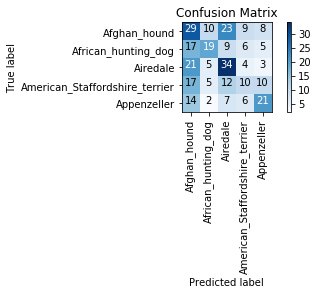

In [117]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(clf, le=le, cmap=plt.cm.Blues, title='Confusion Matrix'):

    cm = confusion_matrix(y_test, clf.predict(X_test))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [le.inverse_transform(x) for x in range(cm.shape[0])]
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#plot_confusion_matrix(pipekpcolor)

# Scoring method

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

scorer = make_scorer(accuracy_score)

# Cross Validation

In [40]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)


## KP only

## Classifier creation

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
listpipek = [('stdcol', Standselector('colors')), ('kmcol',KmeansPlus()), ('cvectcol', CvectPlus()), ('rfc',RandomForestClassifier(n_estimators=100))]
pipekpcolor = Pipeline(listpipek)
pipekpcolor.fit(X_train, y_train)

pipekpcolor.score(X_test, y_test)

0.369281045751634

In [45]:
accuracy_score(y_test, pipekpcolor.predict(X_test))

0.369281045751634

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

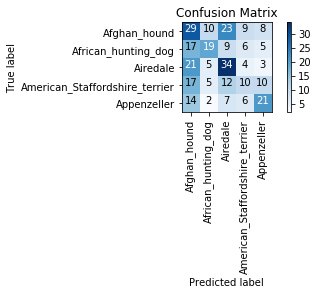

In [118]:
plot_confusion_matrix(pipekpcolor)

## Gridsearch

In [53]:
from sklearn.model_selection import GridSearchCV

parameters = {'kmcol__n_clusters':[220,190,200, 210],}

clfkpgs = GridSearchCV(pipekpcolor, param_grid=parameters, scoring=scorer, n_jobs=-2, cv=skf, verbose=5)
#clfkpancolorgs
clfkpgs.fit(X_train, y_train)
#clfkpancolorgs.get_params().keys()

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] kmcol__n_clusters=220 ...........................................
[CV] kmcol__n_clusters=220 ...........................................
[CV] . kmcol__n_clusters=220, score=0.33653846153846156, total=   6.9s
[CV] kmcol__n_clusters=220 ...........................................
[CV] .. kmcol__n_clusters=220, score=0.3671497584541063, total=   6.8s
[CV] kmcol__n_clusters=190 ...........................................
[CV] . kmcol__n_clusters=220, score=0.38235294117647056, total=   7.2s
[CV] kmcol__n_clusters=190 ...........................................
[CV] . kmcol__n_clusters=190, score=0.35096153846153844, total=   6.4s
[CV] kmcol__n_clusters=190 ...........................................
[CV] ... kmcol__n_clusters=190, score=0.357487922705314, total=   6.2s
[CV] kmcol__n_clusters=200 ...........................................
[CV] .. kmcol__n_clusters=190, score=0.3284313725490196, total=   6.2s
[CV] kmcol__n_clu

[Parallel(n_jobs=-2)]: Done  10 out of  12 | elapsed:   48.3s remaining:    9.7s


[CV] kmcol__n_clusters=210 ...........................................
[CV] .. kmcol__n_clusters=210, score=0.3671497584541063, total=   6.2s
[CV] . kmcol__n_clusters=210, score=0.36764705882352944, total=   6.3s


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:   56.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('stdcol', Standselector(column='colors')), ('kmcol', KmeansPlus(n_clusters=50, random_state=0, verbose=0)), ('cvectcol', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_d...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'kmcol__n_clusters': [220, 190, 200, 210]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=5)

In [54]:
clfkpgs.score(X_test, y_test)

0.369281045751634

In [55]:
clfkpgs.best_params_

{'kmcol__n_clusters': 210}

# KP and colors

In [56]:
clflist = [('featureasm',featureasm), ('rfc',RandomForestClassifier(n_estimators=100))]
clfpipe = Pipeline(clflist)

In [57]:
clfpipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('featureasm', FeatureUnion(n_jobs=2,
       transformer_list=[('kp', Pipeline(memory=None,
     steps=[('stdkp', Standselector(column='kp')), ('kmkp', KmeansPlus(n_clusters=50, random_state=0, verbose=0)), ('cvectkp', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1))])), (...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [58]:
clfpipe.score(X_test, y_test)

0.48366013071895425

## Key point optimization

In [61]:
clflist = [('featureasm',featureasm), ('rfc',RandomForestClassifier(n_estimators=1000, max_depth=100))]
clfpipe = Pipeline(clflist)

parameters = {'featureasm__kp__kmkp__n_clusters':[225, 175, 200],
              'featureasm__color__kmcol__n_clusters':[6,10,15]}

clfkpcolorsgs = GridSearchCV(clfpipe, param_grid=parameters, n_jobs=-2, scoring=scorer, cv=skf, verbose=5)

clfkpcolorsgs.fit(X_train, y_train)
#clfkpcolorsgs.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225 
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225 
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, score=0.4326923076923077, total=  33.3s
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, score=0.3526570048309179, total=  32.0s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175 
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, score=0.4068627450980392, total=  30.8s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:  4.6min


[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, score=0.42788461538461536, total=  58.6s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, score=0.3961352657004831, total=  37.5s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, score=0.4215686274509804, total=  52.3s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, score=0.47115384615384615, total= 1.3min
[CV] featureasm__color__kmcol__n_clusters=15, featureasm__kp__kmkp__n_clusters=225 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_cluster

[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed: 21.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featureasm', FeatureUnion(n_jobs=1,
       transformer_list=[('kp', Pipeline(memory=None,
     steps=[('stdkp', Standselector(column='kp')), ('kmkp', KmeansPlus(n_clusters=50, random_state=0, verbose=0)), ('cvectkp', CvectPlus(analyzer='word', max_df=1.0, max_features=None, min_df=1))])), (...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'featureasm__kp__kmkp__n_clusters': [225, 175, 200], 'featureasm__color__kmcol__n_clusters': [6, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=5)

In [62]:
clfkpcolorsgs.score(X_test, y_test)

0.4215686274509804

In [63]:
clfkpcolorsgs.best_params_

{'featureasm__color__kmcol__n_clusters': 6,
 'featureasm__kp__kmkp__n_clusters': 200}

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

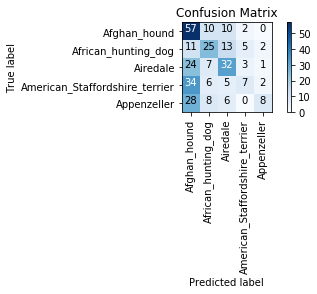

In [119]:
plot_confusion_matrix(clfkpcolorsgs)

# Knearest neighbour

In [84]:
from sklearn.neighbors import KNeighborsClassifier
knnlist = [('featureasm',featureasm), ('knn',KNeighborsClassifier())]
knnpipe = Pipeline(knnlist)

In [90]:
parameters = {'featureasm__kp__kmkp__n_clusters':[200, 175, 150],
              'featureasm__color__kmcol__n_clusters':[12,14, 16],
              'knn__n_neighbors':[4, 5, 6]}

knnkpcolorsgs = GridSearchCV(knnpipe, param_grid=parameters, scoring=scorer, n_jobs=1, cv=skf, verbose=5)

knnkpcolorsgs.fit(X_train, y_train)
knnkpcolorsgs.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=4 
[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=4, score=0.3557692307692308, total=  19.4s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.0s remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=4, score=0.357487922705314, total=  18.7s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.3s remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=4, score=0.36764705882352944, total=  18.3s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=5, score=0.3317307692307692, total=  19.6s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=5, score=0.28019323671497587, total=  18.9s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=5 
[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=5, score=0.4117647058823529, total=  19.4s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=6 
[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=6, score=0.4230769230769231, total=  19.0s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=6 
[CV]  featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=6, score=0.32367149758454106, total=  19.1s
[CV] featureasm__color__kmcol__n_clusters=12, featureasm__kp__kmkp__n_clusters=200, knn__n_neighbors=6 
[C

[CV]  featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=4, score=0.3864734299516908, total=  17.9s
[CV] featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=4 
[CV]  featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=4, score=0.4362745098039216, total=  18.0s
[CV] featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=5 
[CV]  featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=5, score=0.35096153846153844, total=  17.4s
[CV] featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=5 
[CV]  featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=5, score=0.33816425120772947, total=  18.0s
[CV] featureasm__color__kmcol__n_clusters=14, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=5 
[C

[CV]  featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=6, score=0.3285024154589372, total=  17.6s
[CV] featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=6 
[CV]  featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=175, knn__n_neighbors=6, score=0.39215686274509803, total=  18.6s
[CV] featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=150, knn__n_neighbors=4 
[CV]  featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=150, knn__n_neighbors=4, score=0.38461538461538464, total=  17.1s
[CV] featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=150, knn__n_neighbors=4 
[CV]  featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=150, knn__n_neighbors=4, score=0.3285024154589372, total=  16.9s
[CV] featureasm__color__kmcol__n_clusters=16, featureasm__kp__kmkp__n_clusters=150, knn__n_neighbors=4 
[C

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 26.5min finished


{'featureasm__color__kmcol__n_clusters': 14,
 'featureasm__kp__kmkp__n_clusters': 175,
 'knn__n_neighbors': 4}

In [91]:
knnkpcolorsgs.score(X_test, y_test)

0.3627450980392157

In [92]:
knnkpcolorsgs.best_params_

{'featureasm__color__kmcol__n_clusters': 14,
 'featureasm__kp__kmkp__n_clusters': 175,
 'knn__n_neighbors': 4}

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

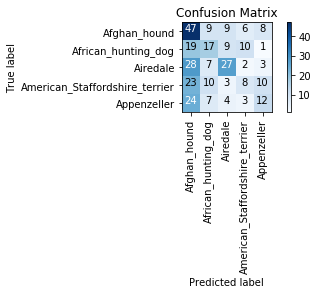

In [120]:
plot_confusion_matrix(knnkpcolorsgs)

# Linear SVC

In [80]:
from sklearn.svm import LinearSVC
svclist = [('featureasm',featureasm), ('svc',LinearSVC(random_state=0, multi_class='crammer_singer'))]
svcpipe = Pipeline(svclist)

In [81]:
parameters = {'featureasm__kp__kmkp__n_clusters':[225, 175, 200],
              'featureasm__color__kmcol__n_clusters':[6,8,10],
              'svc__C':np.logspace(-3,3,6)}

svckpcolorsgs = GridSearchCV(svcpipe, param_grid=parameters, scoring=scorer, n_jobs=1, cv=skf, verbose=5)

svckpcolorsgs.fit(X_train, y_train)
svckpcolorsgs.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.001 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.001, score=0.4519230769230769, total=  21.3s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.001, score=0.34299516908212563, total=  20.1s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.8s remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.001, score=0.4166666666666667, total=  20.5s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.015848931924611134 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.015848931924611134, score=0.40865384615384615, total=  21.2s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.015848931924611134 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.015848931924611134, score=0.36231884057971014, total=  20.9s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.015848931924611134 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.015848931924611134, score=0.4068627450980392, total=  21.4s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.25118864315095796 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.25118864315095796, score=0.3701923076923077, total=  20.2s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.25118864315095796 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, svc__C=0.25118864315095796, score=0.3671497584541063, total=  20.7s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm

[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.001, score=0.41545893719806765, total=  19.1s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.001 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.001, score=0.4362745098039216, total=  19.1s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.015848931924611134 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.015848931924611134, score=0.375, total=  19.4s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.015848931924611134 
[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.015848931924611134, score=0.391304347826087, total=  19.3s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, svc__C=0.015848931924611134

[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, svc__C=1000.0, score=0.3333333333333333, total=  20.8s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, svc__C=1000.0 
[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, svc__C=1000.0, score=0.37745098039215685, total=  21.0s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, svc__C=0.001 
[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, svc__C=0.001, score=0.3894230769230769, total=  18.7s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, svc__C=0.001 
[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, svc__C=0.001, score=0.4057971014492754, total=  17.9s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, svc__C=0.001 
[CV]  featureasm__color__kmcol__n_clusters=8, featureasm

[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=63.0957344480193, score=0.40096618357487923, total=  19.7s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=63.0957344480193 
[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=63.0957344480193, score=0.37745098039215685, total=  20.1s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=1000.0 
[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=1000.0, score=0.33653846153846156, total=  20.4s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=1000.0 
[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=1000.0, score=0.391304347826087, total=  19.2s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, svc__C=1000.0 
[CV]  featureasm__co

[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, svc__C=3.981071705534969, score=0.3140096618357488, total=  19.2s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, svc__C=3.981071705534969 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, svc__C=3.981071705534969, score=0.35294117647058826, total=  19.4s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, svc__C=63.0957344480193 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, svc__C=63.0957344480193, score=0.34615384615384615, total=  19.2s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, svc__C=63.0957344480193 
[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, svc__C=63.0957344480193, score=0.391304347826087, total=  18.8s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 58.1min finished


{'featureasm__color__kmcol__n_clusters': 10,
 'featureasm__kp__kmkp__n_clusters': 200,
 'svc__C': 0.001}

In [82]:
svckpcolorsgs.score(X_test, y_test)

0.42810457516339867

In [83]:
svckpcolorsgs.best_params_

{'featureasm__color__kmcol__n_clusters': 10,
 'featureasm__kp__kmkp__n_clusters': 200,
 'svc__C': 0.001}

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

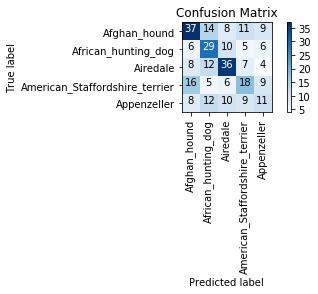

In [121]:
plot_confusion_matrix(svckpcolorsgs)

# XGboost

In [97]:
import xgboost as xgb

ind_params = {'learning_rate': 0.1, 'n_estimators': 10, 'objective': 'multi:softmax', 'tree_method':'hist'}

xgblist = [('featureasm',featureasm), ('xgb',xgb.XGBClassifier(**ind_params))]
xgbpipe = Pipeline(xgblist)

In [99]:
# STep 1

parameters = {'xgb__max_depth': range(50,101,25),
              #'min_child_weight': range(1,6,2),
              'featureasm__kp__kmkp__n_clusters':[225, 175, 200],
              'featureasm__color__kmcol__n_clusters':[6,8,10],}

xgbcclf = GridSearchCV(xgbpipe, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5)
xgbcclf.fit(X_train, y_train)
xgbcclf.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.28846153846153844, total=  26.5s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.34782608695652173, total=  25.7s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.31862745098039214, total=  26.5s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.3605769230769231, total=  27.6s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.3671497584541063, total=  27.4s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.3088235294117647, total=  27.5s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.33653846153846156, total=  28.9s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.3140096618357488, total=  28.5s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.29901960784313725, total=  28.6s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.375, total=  24.3s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.2995169082125604, total=  23.7s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.3137254901960784, total=  23.5s


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  2.4min


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.34134615384615385, total=  25.6s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.37681159420289856, total=  25.2s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.37254901960784315, total=  24.4s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.2932692307692308, total=  23.6s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.357487922705314, total=  24.0s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.30392156862745096, total=  23.0s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.33653846153846156, total=  24.4s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.2946859903381642, total=  24.4s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.3284313725490196, total=  24.4s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.3317307692307692, total=  24.4s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.2995169082125604, total=  24.0s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.3284313725490196, total=  24.9s
[CV] featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.34615384615384615, total=  26.7s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.3719806763285024, total=  27.1s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=6, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.31862745098039214, total=  25.8s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.33653846153846156, total=  32.0s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.3526570048309179, total=  31.0s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.3480392156862745, total=  31.9s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.3317307692307692, total=  45.1s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.3140096618357488, total=  42.2s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.35294117647058826, total=  30.5s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.2932692307692308, total=  29.7s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.3719806763285024, total=  27.5s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.3088235294117647, total=  26.8s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.3125, total=  22.7s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.34299516908212563, total=  22.4s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.3480392156862745, total=  23.3s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.38461538461538464, total=  23.2s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.28502415458937197, total=  23.4s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.3382352941176471, total=  24.0s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.34134615384615385, total=  24.7s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.30434782608695654, total=  24.8s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.35294117647058826, total=  27.6s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.3173076923076923, total=  30.9s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.33816425120772947, total=  29.0s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.3235294117647059, total=  46.0s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.2980769230769231, total= 1.2min
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.391304347826087, total=  51.0s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.27450980392156865, total=  44.7s
[CV] featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.28846153846153844, total=  27.0s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.391304347826087, total=  24.4s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=8, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.29411764705882354, total=  25.1s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.3173076923076923, total=  26.6s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.34782608695652173, total=  26.5s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=50, score=0.29901960784313725, total=  26.2s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.3557692307692308, total=  25.9s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.33816425120772947, total=  26.1s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=75, score=0.31862745098039214, total=  26.9s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.33653846153846156, total=  28.7s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.3333333333333333, total=  29.9s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=225, xgb__max_depth=100, score=0.3088235294117647, total=  30.4s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.4182692307692308, total=  25.9s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.3526570048309179, total=  25.8s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=50, score=0.35294117647058826, total=  35.3s


[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 13.5min


[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.35096153846153844, total=  36.0s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.3671497584541063, total=  37.4s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=75, score=0.3284313725490196, total= 1.3min
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.3557692307692308, total= 1.6min
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.357487922705314, total= 1.2min
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.3798076923076923, total=  24.9s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=175, xgb__max_depth=100, score=0.31862745098039214, total= 1.4min
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.3188405797101449, total=  24.8s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=50, score=0.36764705882352944, total=  26.0s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.25961538461538464, total=  25.6s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.28502415458937197, total=  24.5s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=75, score=0.35784313725490197, total=  25.1s
[CV] featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100 


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.3269230769230769, total=  25.8s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.30917874396135264, total=  26.0s


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  featureasm__color__kmcol__n_clusters=10, featureasm__kp__kmkp__n_clusters=200, xgb__max_depth=100, score=0.3382352941176471, total=  21.7s


[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed: 17.8min finished


{'featureasm__color__kmcol__n_clusters': 10,
 'featureasm__kp__kmkp__n_clusters': 175,
 'xgb__max_depth': 50}

In [100]:
xgbcclf.score(X_test, y_test)

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.3888888888888889

# TO UPDTATE AFTER THAT !!!!

In [ ]:
# Step 2

step2 = {**xgbcclf1.best_params_, **step1}
parameters = {'gamma':[i/10.0 for i in range(0,3)]}
xgbc2 = xgb.XGBClassifier(**step2)
xgbcclf2 = GridSearchCV(xgbc2, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
xgbcclf2.fit(X_train_scaled, ytrain[parametertoclass])
xgbcclf2.score(X_test_scaled, ytest[parametertoclass])

In [ ]:
# Step 3


#Gridsearch creation - XGBoostingClassifier - Step 3
step3 = {**xgbcclf2.best_params_, **step2}

parameters = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
xgbc3 = xgb.XGBClassifier(**step3)
xgbcclf3 = GridSearchCV(xgbc3, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
xgbcclf3.fit(X_train_scaled, ytrain[parametertoclass])
xgbcclf3.score(X_test_scaled, ytest[parametertoclass])



In [ ]:
# Step 4

#Gridsearch creation - XGBoostingClassifier - Step 4
step4 = {**xgbcclf3.best_params_, **step3}

parameters = {'learning_rate':[0.01, 0.05, 0.1]}
xgbc4 = xgb.XGBClassifier(**step4)
xgbcclf4 = GridSearchCV(xgbc4, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
xgbcclf4.fit(X_train_scaled, ytrain[parametertoclass])
xgbcclf4.score(X_test_scaled, ytest[parametertoclass])